In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_2 as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.props as props
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
from apra_pop_models.imshows import *

model = fraunhofer.CORO()

FN = 500
optimal_dm1_dm2 = (model.pupil_diam**2/(model.wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

reload(utils)
WFE = xp.array(fits.getdata('/npool/nvme/kianmilani/wfe-data/coro_wfe.fits'))
WFE = WFE[0] * xp.exp(1j*2*np.pi*WFE[1]/model.wavelength_c.to_value(u.m))
wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*model.wavelength_c.to_value(u.m)/(2*np.pi)
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[model.APMASK]-xp.mean(wfe_amp[model.APMASK]))))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[model.APMASK])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.2e}', f'{rms_opd:.3e}')



influence function sampling 15.625
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


<Quantity 1134.27692308 mm>

FileNotFoundError: [Errno 2] No such file or directory: '/npool/nvme/kianmilani/wfe-data/coro_wfe.fits'

In [19]:
68*0.3

20.4

In [21]:
19.2/20.4 * 0.9 * 68/2

28.8

influence function sampling 15.625
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


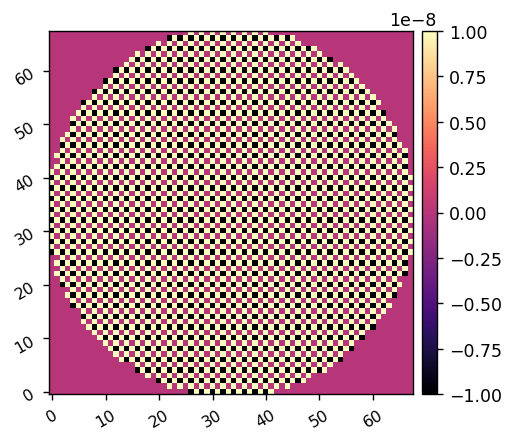

0.0004677187468186002


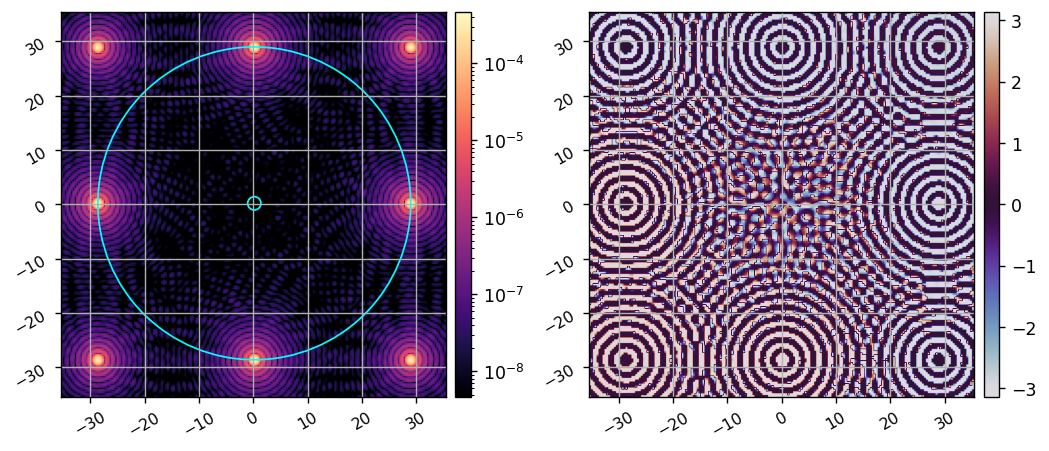

In [4]:
reload(fraunhofer)
reload(apra_pop_models.props)
model = fraunhofer.CORO()
model.npsf = 200
# model.reverse_parity = True
# model.WFE = WFE

model.Imax_ref = xp.max(model.snap())

pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio/0.9
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 25
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

waffle_command = 10e-9 * xp.ones((model.Nact,model.Nact))
waffle_command[::2,::2] *= -1
waffle_command[1::2, 1::2] = 0
imshow1(waffle_command*model.dm_mask)
model.set_dm1(waffle_command)

model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2
print(xp.max(im))
imshow2(im, xp.angle(wfs[-1]), lognorm1=True, vmin1=xp.max(im)/1e5, cmap2='twilight', 
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 28.8, fill=False, color='cyan')])


In [56]:
ref_coro_im.shape

(200, 200)

In [6]:
model.psf_pixelscale, model.psf_pixelscale_lamD

(<Quantity 5.e-06 m / pix>, 0.35076923076923083)

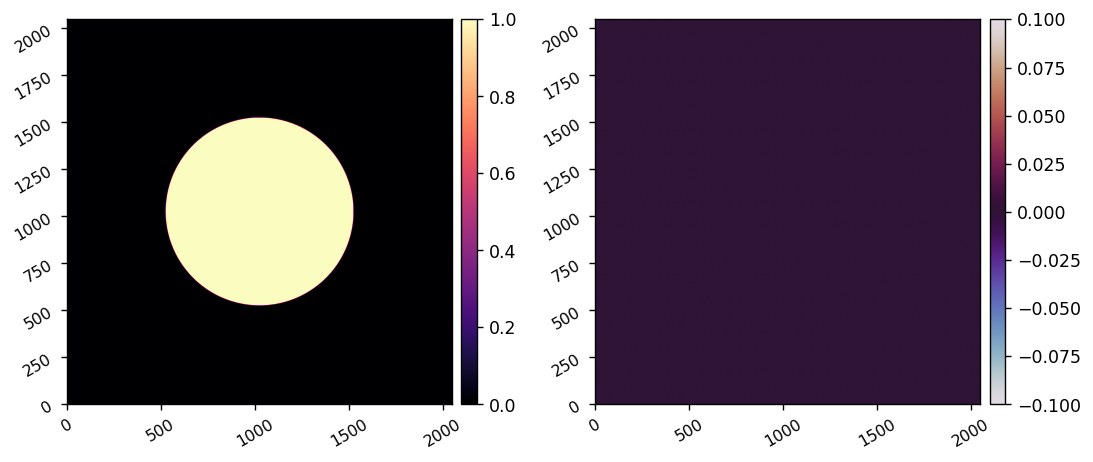

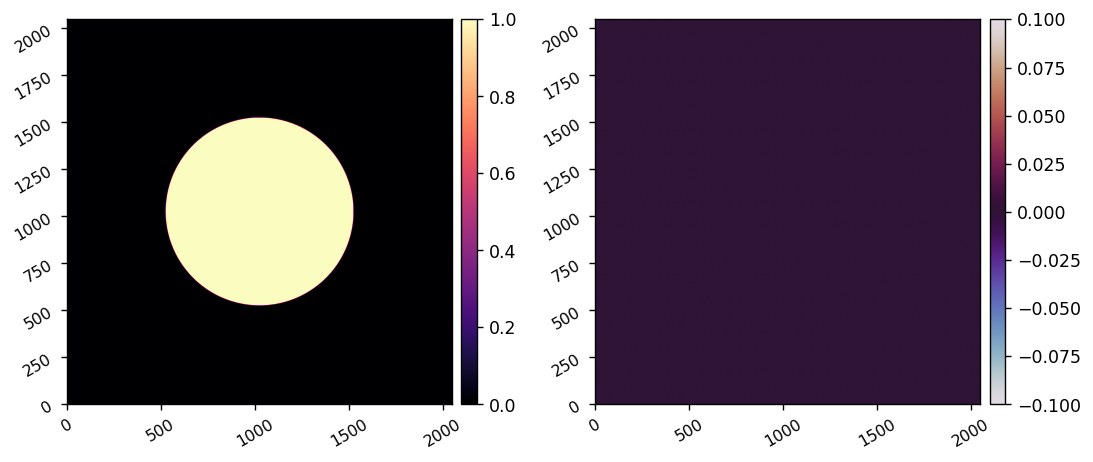

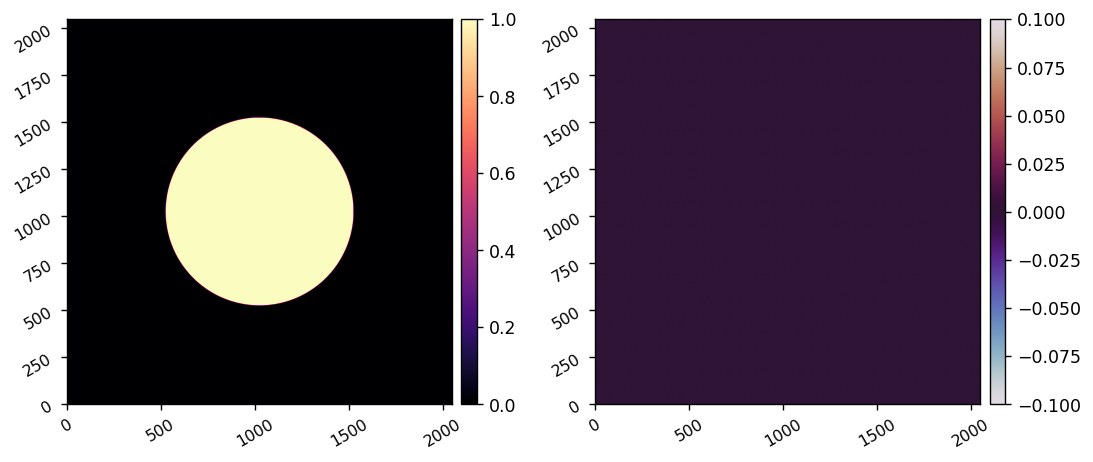

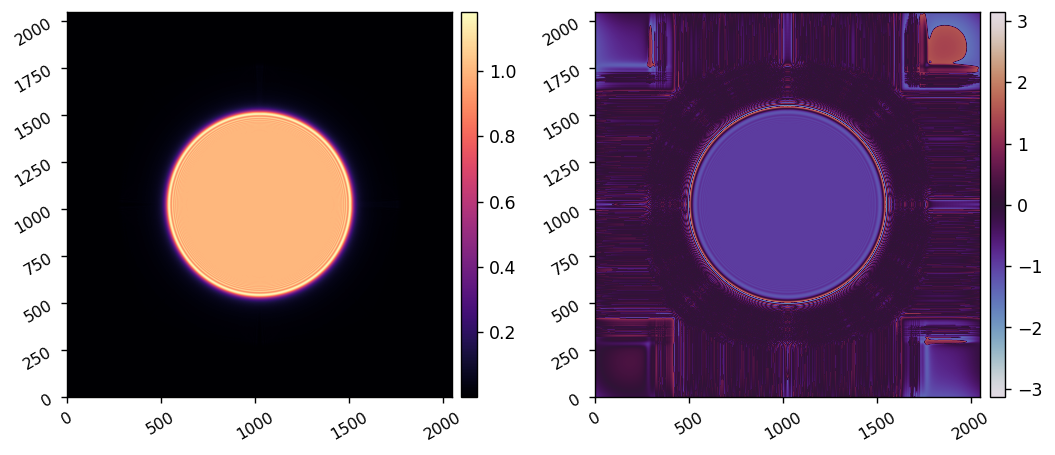

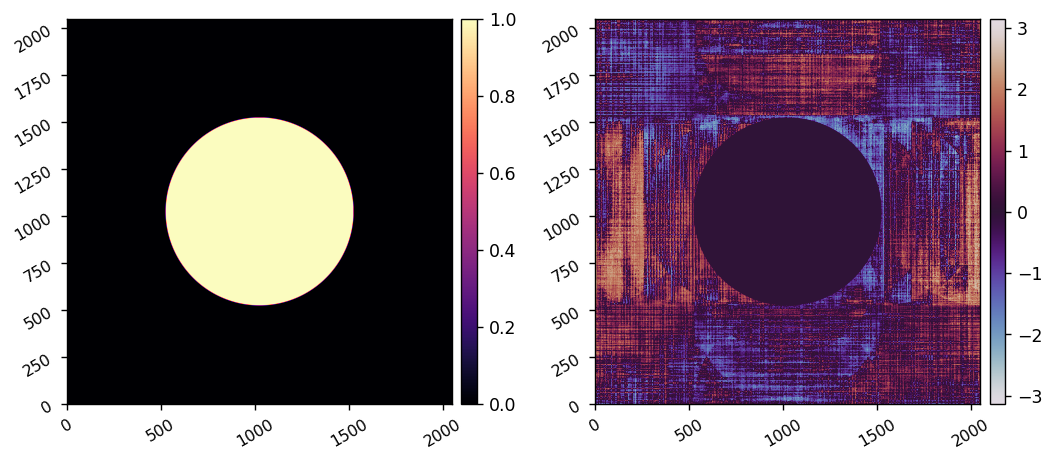

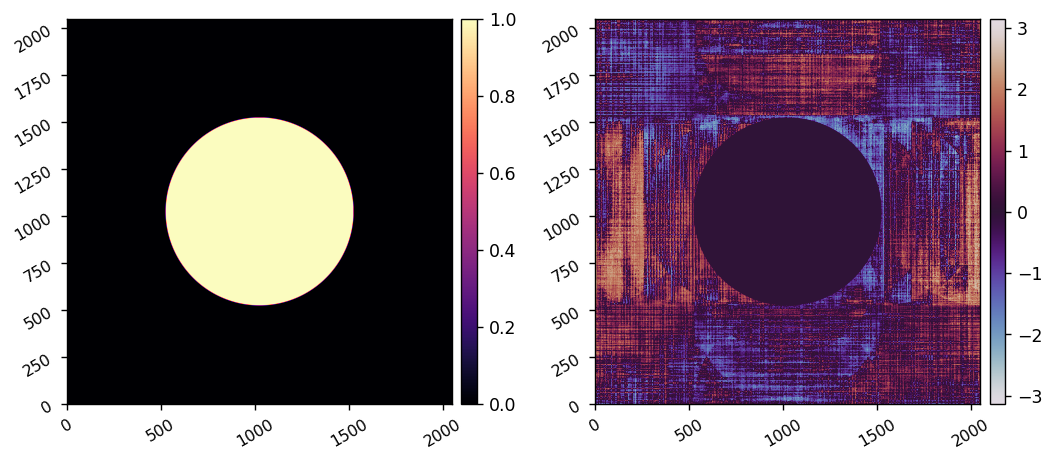

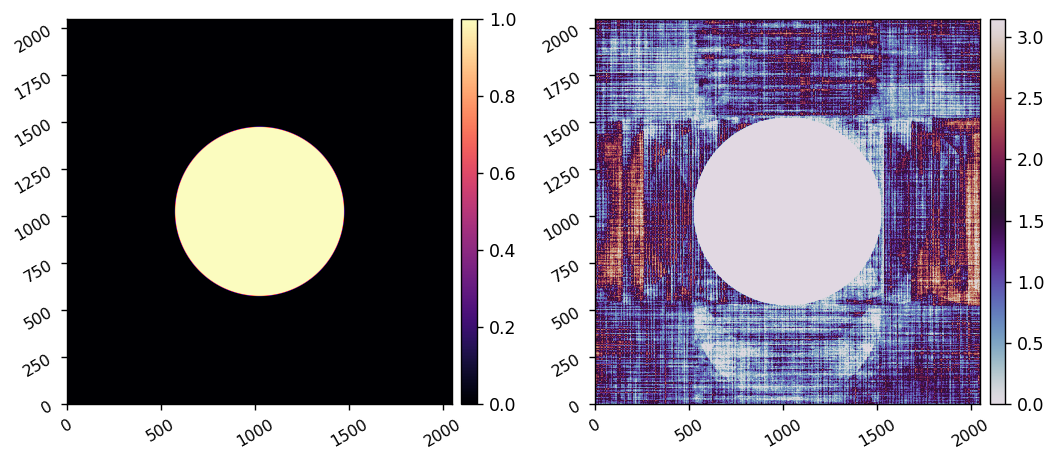

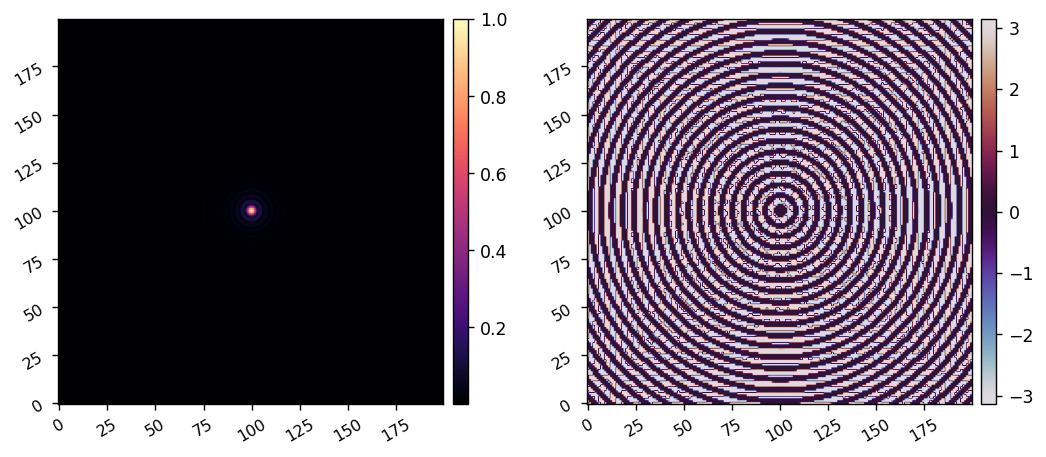

In [7]:
for i,wf in enumerate(wfs):
    imshow2(xp.abs(wf), xp.angle(wf),
            cmap1='magma', cmap2='twilight')

influence function sampling 15.625
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


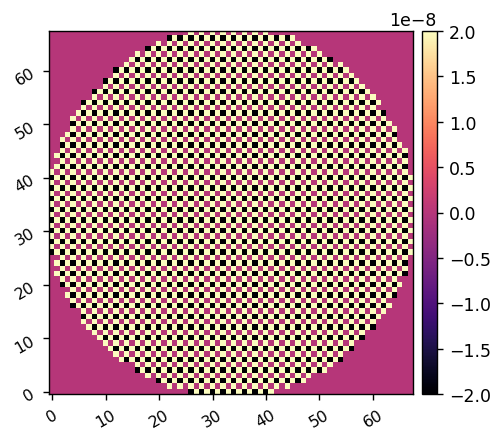

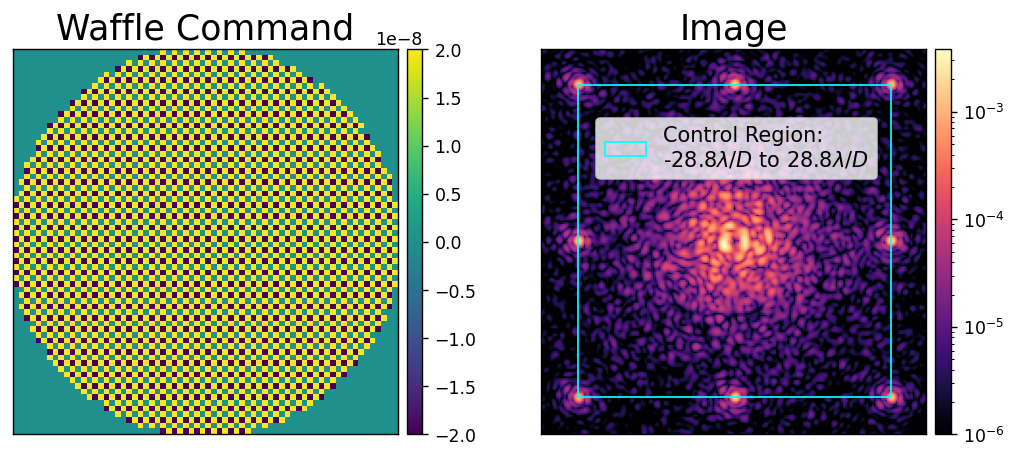

In [6]:
model = fraunhofer.CORO()
model.npsf = 200
model.reverse_parity = True
model.WFE = WFE

ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

waffle_command = 20e-9 * xp.ones((model.Nact,model.Nact))
waffle_command[::2,::2] *= -1
waffle_command[1::2, 1::2] = 0
imshow1(waffle_command*model.dm_mask)
model.set_dm1(waffle_command)

dm_surf = model.DM1.get_surface()

waffle_im = model.snap()

max_sf = 28.8

fig,ax =imshow2(waffle_command, waffle_im, 
                cmap1='viridis',
                cmap2='magma', lognorm2=True, vmin2=1e-6,
                pxscl2=model.psf_pixelscale_lamD,
                patches2=[Rectangle((-28.8+model.psf_pixelscale_lamD/2, -28.8+model.psf_pixelscale_lamD/2), 28.8*2, 28.8*2, fill=False, color='cyan', 
                                  label='Control Region:\n-28.8$\lambda/D$ to 28.8$\lambda/D$')],
                wspace=0.2,
                display_fig=False, return_fig=True,)
ax[0].set_title('Waffle Command', fontsize=20)
ax[1].set_title('Image', fontsize=20)
ax[1].legend(loc='upper right', bbox_to_anchor=[0.9,0.85], fontsize=12)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
display(fig)

influence function sampling 15.625
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


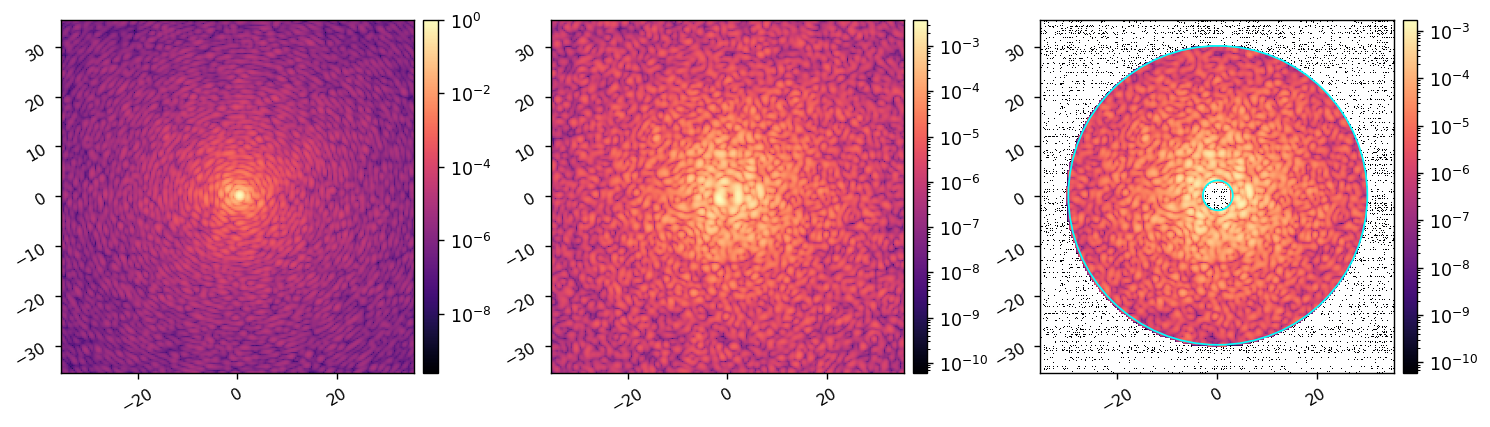

In [23]:
model = fraunhofer.CORO()
model.npsf = 200
model.reverse_parity = True
model.WFE = WFE

ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

ref_coro_im = model.snap()

control_mask = efc_utils.create_annular_focal_plane_mask(model, 3, 30)
imshow3(ref_psf/model.Imax_ref, ref_coro_im, control_mask*ref_coro_im, 
        lognorm=True, pxscl=model.psf_pixelscale_lamD,
        patches3=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 3, fill=False, color='cyan'), 
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 30, fill=False, color='cyan')])

In [14]:
model.dm_mask.sum()

array(3720)

In [5]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask, ndms=2)

Calculating Jacobian: 
	Calculated response for mode 7440/7440. Elapsed time=343.210 sec.
Jacobian built in 343.210 sec


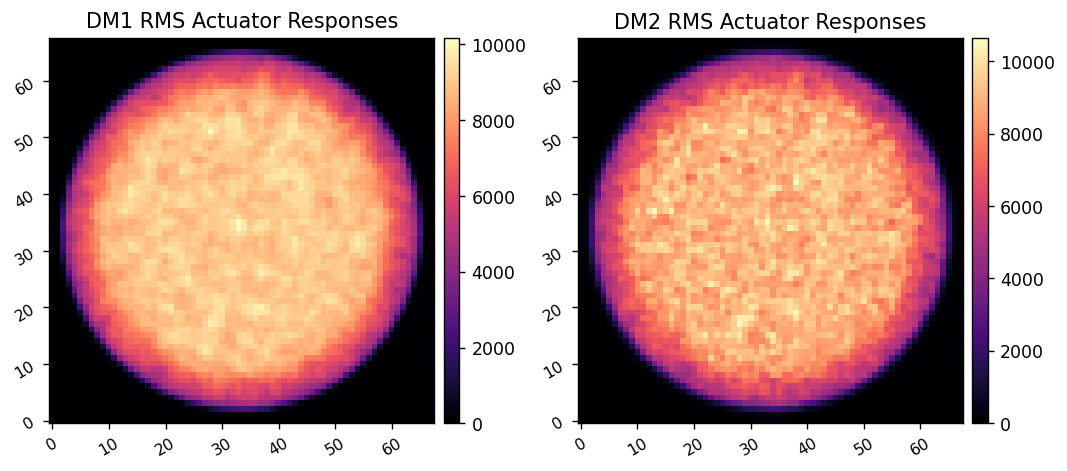

In [6]:
reload(efc)
jac = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [7]:
model.reset_dms()

images = xp.array([ref_coro_im])
dm1_commands = xp.array([model.get_dm1()])
dm2_commands = xp.array([model.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 10/12.
	Mean NI of this iteration: 1.721e-07


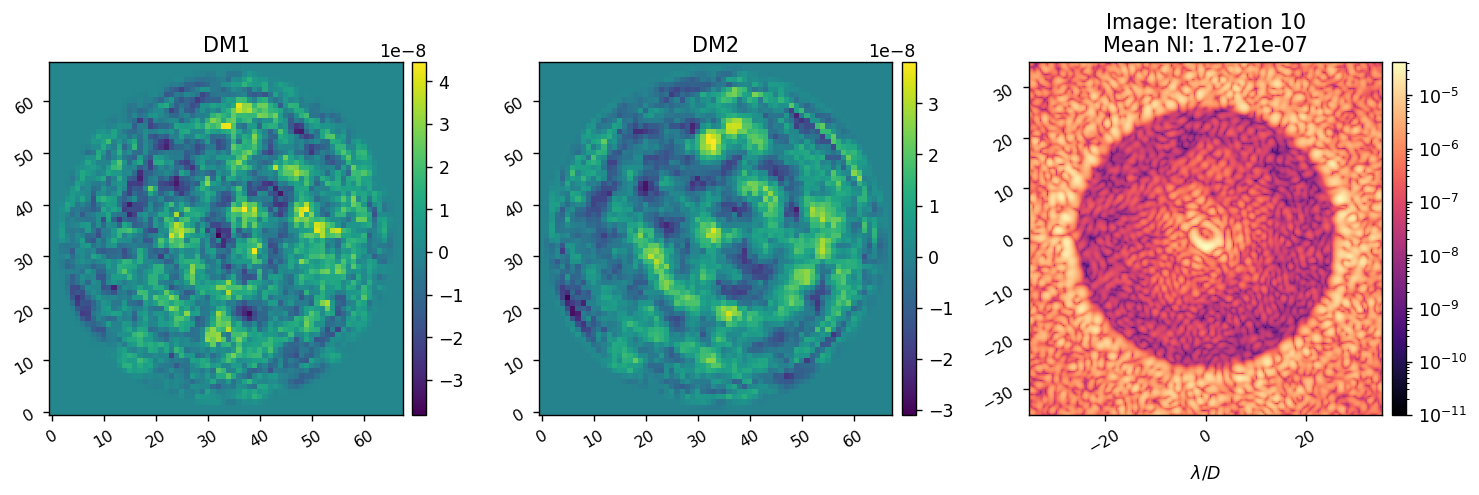

	Running iteration 11/12.
	Mean NI of this iteration: 1.383e-07


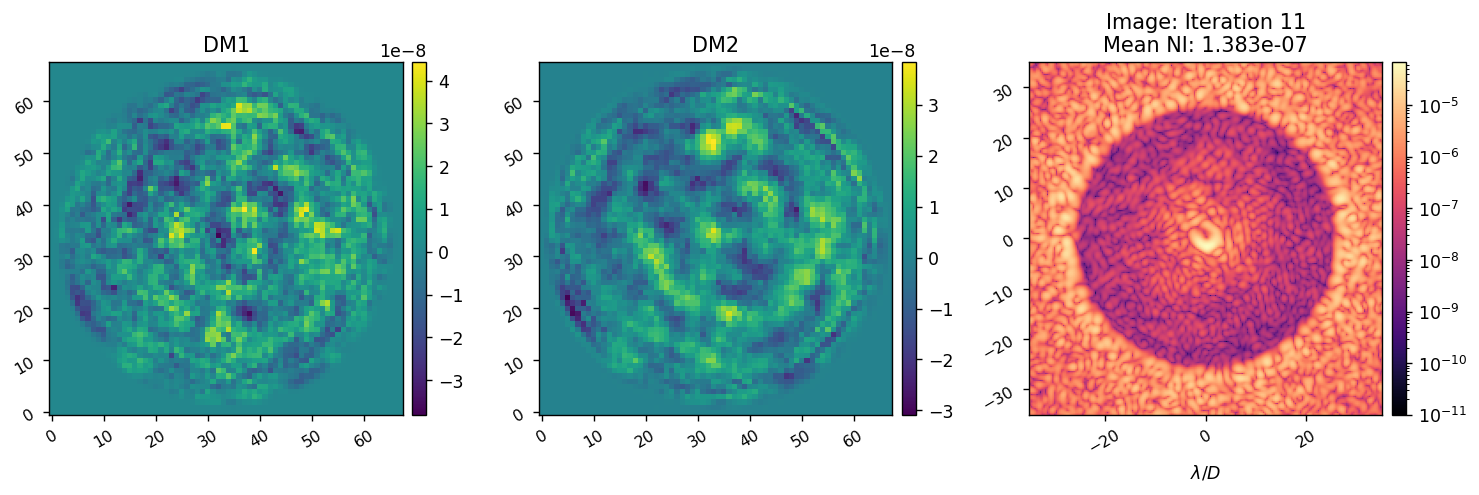

	Running iteration 12/12.
	Mean NI of this iteration: 1.205e-07


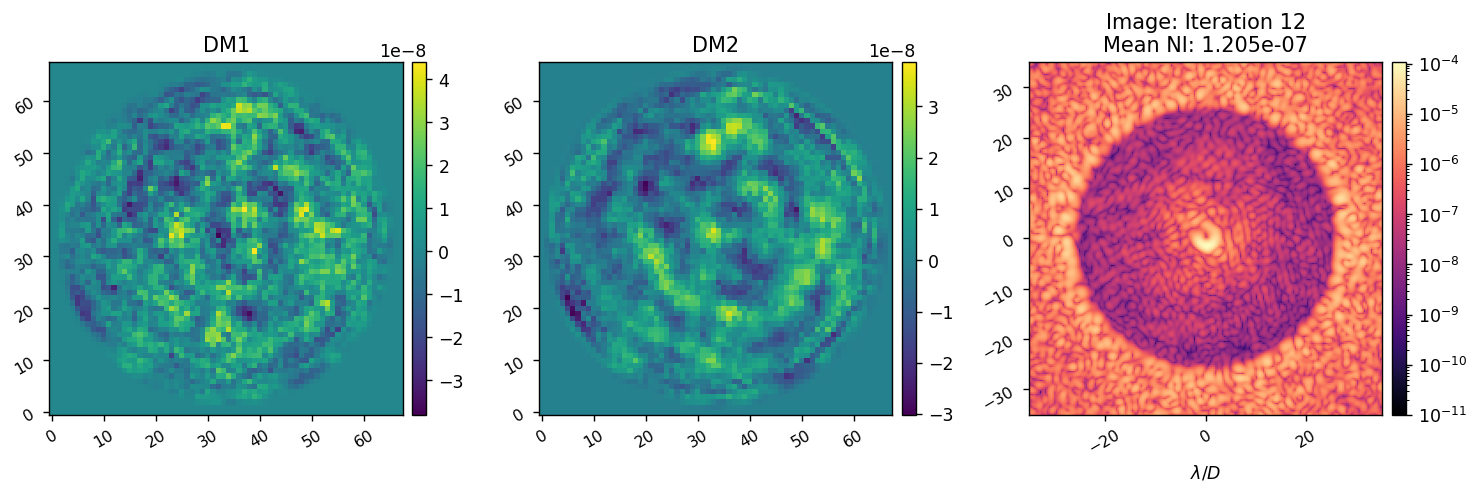

EFC completed in 4.259 sec.


In [11]:
reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(model, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    # control_matrix,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )

Calculating Jacobian: 
	Calculated response for mode 7440/7440. Elapsed time=349.675 sec.
Jacobian built in 349.675 sec


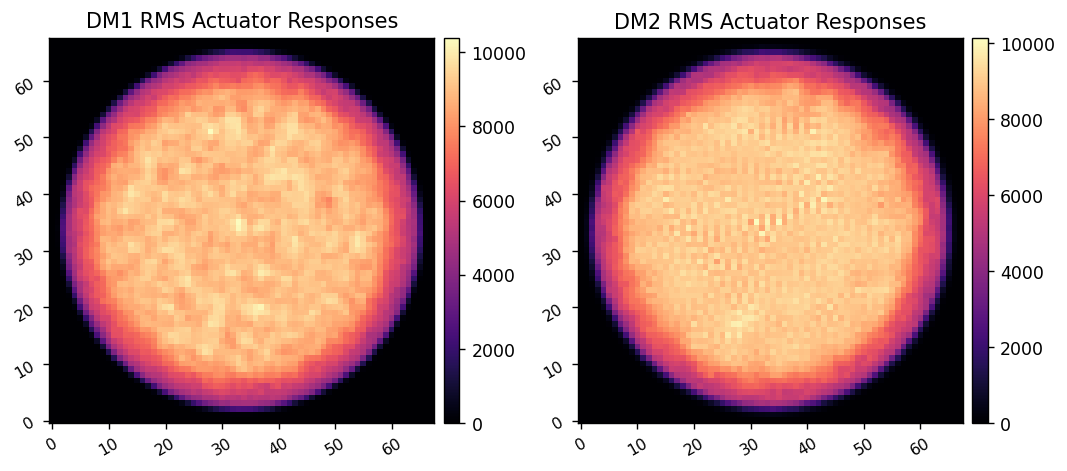

In [17]:
reload(efc)
jac_12 = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [1]:
reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(model, 
                                                    jac_12, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    # control_matrix,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )

NameError: name 'efc_utils' is not defined